# Notes and TODOs 

- Sometimes, we repeat the explanation of certain aspects
- The explanation of the windowing is unclear / Multiple different steps are referred to as windowing at the same time. Possibly, it will be necessary to update the Methodology figure from the paper.

In [27]:
%load_ext autoreload
%autoreload 2

from conscious_engie_icare.data.phm_data_handler import CACHING_FOLDER_NAME, fetch_and_unzip_data, \
                                                        load_data, BASE_PATH_HEALTHY, BASE_PATHS_TEST, PITTING_LEVELS, \
                                                        FPATH_DISTANCES
from conscious_engie_icare.nmf_profiling import extract_nmf_per_number_of_component, extract_nmf_incremental, \
                                                derive_df_vib, derive_df_orders
from conscious_engie_icare.viz.viz import illustrate_nmf_components_for_paper, illustrate_nmf_components_interactive
from conscious_engie_icare import distance_metrics
from conscious_engie_icare.normalization import normalize_1
from conscious_engie_icare.util import calculate_roc_characteristics, calc_tpr_at_fpr_threshold, calc_fpr_at_tpr_threshold
from conscious_engie_icare.preprocessing import get_and_preprocess_healthy_data, get_and_preprocess_unhealthy_data
import pickle
import os
import string
import glob
from tqdm import tqdm
from copy import deepcopy
import re
import math
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import kneed
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

from ipywidgets import interact, Layout
import ipywidgets as widgets
from IPython.display import Markdown as md

# ignore convergence warnings (1000 iterations reached by NMF)
import warnings;
warnings.filterwarnings('ignore');

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set CACHE_RESULTS to True to cache the results of the feature extraction process. This will speed up the notebook execution time in subsequent executions.

> CODE: Robbert, do we we still need to cache results? (Maybe not, but) Robbert decides.

# Starter Kit 2: Contextual Performance Profiling and Anomaly Detection

> ToDo: make clear that Anomaly Detection and Performance Profiling has their own code section.


## Business context
Industry 4.0 leverages on the advanced AI technologies to enable anomaly detection and performance profiling of industrial assets operating in different contexts. Context is defined by both internal and external factors, such as operational conditions, environmental variables, and usage patterns. For this reason, context-aware methods are fundamental to identify anomalies and to ensure accurate and reliable asset profiling. These methods allow for real-time monitoring and enable enhanced performance and reduce downtime of assets

## Business goal

The business goal related to this Starter Kit (SK) is to illustrate a data-driven methodology to identify anomalies and profile the performance of assets operating in different contexts, i.e. in terms of process measurements reflecting the internal operations of the asset.
As data-driven methodology, this SK focuses on the methodology develeopped by Fingerhut et al. [] since suitable in real-industial scenarios due to [Fabian, can you complete? You can reformulate the entire sentence trying to highlight why your method is worth/convinient for real industrial scenarios] 

## Application contexts

Contextual anomaly detection and performance profiling play a relevant role in a variety of industrial contexts such as: 

- Rise warning to anticipate and avoid safety-critical conditions 

- Alert inspection to avoid possible downtime and cost corrective maintenance 

- Performance benchmarking 

## Data characteristics and requirements
To showcase the SK is required a dataset that includes: 

- The vibration frequency captured by asset sensors. The captured vibration need to be related to the health state of the assets. 
- Parameters related to the internal operations of the asset.

## Starter Kit outline

The SK is organized in N sections:
- Background. This section provides the knowledge required to fully understand the terminology used in the rest of the document. 
- Data understanding.
  - Preprocessing. This section describes how the raw data is prepared for the analysis
  > Preprocessing should be part of section DataUnderstanding
- Methodology. This section illustrates how the methodology introduced by Fingerhut et al. [add reference] can be used for performance profiling and anomaly detection of assets/
- Validation
- Conclusions



At the end of the SK you will know how to: 

- Develop a model for anomaly detection and performance profiling 

- Experimentally validate the resulting model and objectively compare it with other approaches 

- Get insights from your dataset. We will present visual and numerical techniques in order to explore your data for identifying interesting patterns [I don't think we do this]


## Background

- **anomaly**: ...
- **operating mode**. An asset can operate in different contexts which can influence its behavior. We refer to these context-dependent behaviors as operating modes. As example we can imagine a waterpump which operates in two modes: normal and throttle. These two modes are
 can be isolated analzying the context, i.e. the level of warter flow. [AMUR: This example is ok, however, could you make one fitting the gearbox to be more alligned with the use case?]
- **operating and performance views**. The operating view is composed of the parameters capturing the operating context (e.g. rotation speed, torque). The performance view is composed of the parameters monitoring the performance behaviour (e.g. vibrations).

## Data understanding 

The dataset we will use in this Starter Kit come from the [PHM North America challenge '23](https://data.phmsociety.org/phm2023-conference-data-challenge/). This dataset collect the time series data from a gearbox subject to pitting, i.e. a fatigue failure of the gear tooth.
This dataset includes measurements under varied operating conditions from a healthy state as well as six known fault levels [Fabian: aren't 8 the pitting levels?]. The training data are collected from a range of different operating conditions under 15 different rotational speeds and 6 different torque levels.  For each operating condition, 5 vibration measurements were collected. 
The vibration data is given in the time domain with a sampling rate of 20480Hz. The sampling duration differs between 3 seconds and 12 seconds. For each vibration measurement there are triaxial time-domain vibration measurements available (x, y and z). Below, we visualize a vibration measurement in the three directions, as given by PHM North America. [FFNG: In its current form, it might not be entirely clear how different vibration directions are handled. --> Need to go over that.]

[[source](https://data.phmsociety.org/phm2023-conference-data-challenge/)]

<img src="https://data.phmsociety.org/wp-content/uploads/sites/9/2023/06/PHM2023dc_fig1.png" alt="MarineGEO circle logo" style="height: 375px; width:800px;"/>

A single vibration measurement (rpm=100, torque=500, run=1) has the following shape: (246785, 4)


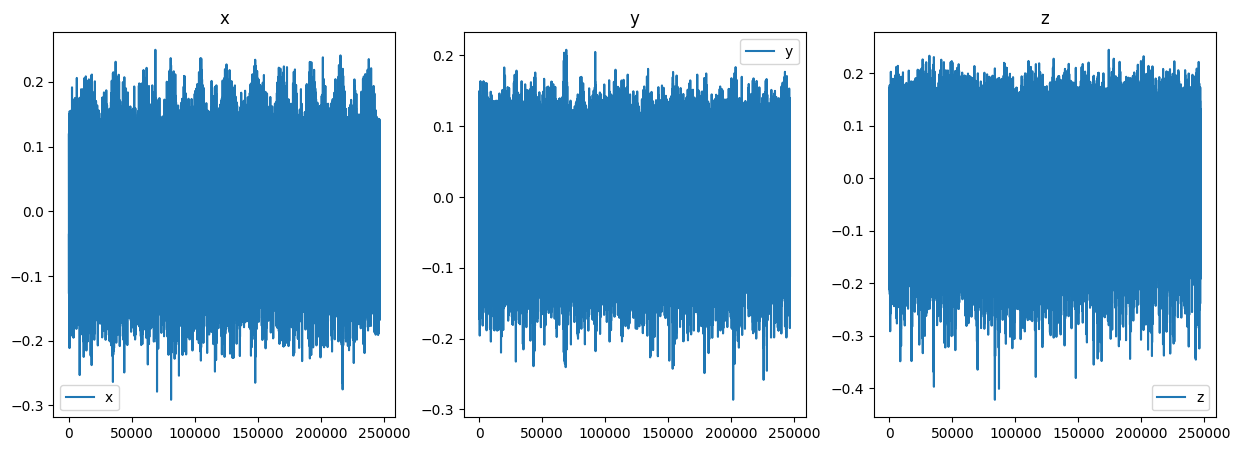

In [2]:
from conscious_engie_icare.data.phm_data_handler import load_train_data  #Import should be put elsewhere

rpm = 100
torque = 500
run = 1
df_example = load_train_data(rpm, torque, run)
print(f"A single vibration measurement (rpm={rpm}, torque={torque}, run={run}) has the following shape: {df_example.shape}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for var, ax in zip(['x', 'y', 'z'], axes):
    ax.plot(df_example[var], label=var)
    ax.set_title(var)
    ax.legend()

## Preprocessing

### Creation of training and testing set.

Splitting the dataset in training and testing is a common activity for validating the machine learning models. The training dataset is used to prepare a model, i.e. to train it, whereas the testing dataset is used to evaluate the performance of the model.
In our case, training and a test set are based on splitting the vibration measurements. More specifically, a random sample of 75% of the original data recorded under normal (= healthy) condition is used for training whereas the remaining 25% is used for testing.  In the rest of the document, we will only refer to this split to analyze the performance of the methodology for the sake of the computational time. On the other hand, to have more reliable results, multiple splits should be performed, i.e. multiple random samples should be extracted for the training and testing set. The interested reader can refer to Fabian et al. [] to see the results when the 100 random splits are generated.



The test set is then created by combining:
1. **Normal condition**: The 25% healthy data that was held back (not used in the training set)
2. **Anomaly condition**: Vibration data characterized by pitting level 1-8. For each level of pitting, there are between 267 and 304 samples in the test set that were recorded at different speeds and torques. 

The figure below illustrates the train-test split.

<img src="figures/overview_train-test-split.png" alt="Overview train-test split" style="width:1000px;"/>


As next step, we preprepare the original data in the training set for the analysis.
- The **time series data** is transformed in frequency-bands. Typically, a frequency band expresses vibration behaviour in a specific range of frequencies (measured in Hertz [Hz]). We define a frequency-band in terms of "orders". Whereas a frequency measured in Hz captures the number of events per second, "orders" capture the number of events per revolution of the rotating element. Therefore, the order-transformation essentially standardizes the data. This step is important and a common preprocessing step in prognostics and health management. All order-transformed vibration measurements are organized in a matrix which we call **performance matrix V**.
- Meta data. The meta data contains the parameters at which the vibrations were measured:
    - The torque expresses the rotational force in terms of Newton meter.
    - The rotation speed expresses, how fast the gearbox is rotation in terms of revolutions per minute.

A brief excerpt of the **performance matrix V** is shown below.

> CODE: Above we report the type of preprocessing we need. Below, the code snippet does not seems to any of this preprocessing. We cannot rely on pickle. This need to be fixed (introductin the preprocessing code).
>
> CODE TO DO (Robbert): remove recompute option here and everywhere else. The code is fast enough that recomputing on the fly is no problem.

In [30]:
# Here we need something to showcase how the training and testing dataset looks like (columns, their meaning, etc)
recompute = True
df_V_train, meta_data_train, df_data_healthy_test, f = get_and_preprocess_healthy_data(recompute=recompute)

# extract list of frequency band columns for later usage
cols_ = df_V_train.columns
BAND_COLS = cols_[cols_.str.contains('band')].tolist()

df_V_train.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:22<00:00, 12.88it/s]


,band_0.5-2.5,band_2.5-4.5,band_4.5-6.5,band_6.5-8.5,band_8.5-10.5,band_10.5-12.5,band_12.5-14.5,band_14.5-16.5,band_16.5-18.5,band_18.5-20.5,...,band_80.5-82.5,band_82.5-84.5,band_84.5-86.5,band_86.5-88.5,band_88.5-90.5,band_90.5-92.5,band_92.5-94.5,band_94.5-96.5,band_96.5-98.5,band_98.5-100.5
index,,,,,,,,,,,,,,,,,,,,,
0,0.000083,0.001135,0.000332,0.000749,0.001604,0.001779,0.002436,0.000905,0.003705,0.000203,...,0.002588,0.004577,0.005826,0.001566,0.003492,0.019335,0.006759,0.009075,0.004589,0.005449
1,0.000030,0.000419,0.000701,0.000212,0.000586,0.000226,0.000414,0.000210,0.000723,0.000209,...,0.003337,0.007597,0.015687,0.003851,0.010378,0.018125,0.005149,0.002389,0.001015,0.001774
2,0.000092,0.000264,0.000134,0.000106,0.001203,0.000446,0.018651,0.012879,0.029916,0.006926,...,0.010886,0.011106,0.026134,0.009216,0.017948,0.095809,0.018065,0.016754,0.004955,0.003817
3,0.001093,0.000285,0.000084,0.000135,0.000072,0.000105,0.000596,0.002880,0.000250,0.000562,...,0.039877,0.013978,0.009773,0.006686,0.010765,0.014013,0.009631,0.006961,0.002484,0.007278
4,0.001949,0.000557,0.000211,0.000272,0.000150,0.000162,0.000396,0.009223,0.000645,0.002202,...,0.016658,0.007494,0.015543,0.010917,0.013567,0.012068,0.006568,0.004345,0.002025,0.003673


The matrix above has n columns which represent vibration measurements and m rows which represent the frequency bins. [Right Fabian?] [**FFNG**: Correct. Once the fold is finalized, I would add the dimensions.] [**FFNG**: How about adding a heatmap instead of showing the head?][AMUR: Open to the idea. However, I currently don't see which worth-to-notice take away message you can convey with the heatmap]

Next, we illustrate the corresponding meta data, consisting of the previously described process parameters `rotational speed [RPM]` and `torque [Nm]`, and some additional information regarding the vibration measurement direction (`direction`) and sample ids (`sample_id` and `unique_sample_id`). Each row corresponds to the same row in the performance matrix. For instance, the very first measurement contains vibrations recorded at 100 RPM and 300 NM, for the vibration measurement direction x.
[**FFNG**: Note that we will not use folds.]

In [4]:
meta_data_train.head()

,rotational speed [RPM],torque [Nm],direction,sample_id,unique_sample_id
0,3000,50,psd_x,4,3000_50_4
1,3000,50,psd_y,4,3000_50_4
2,3000,50,psd_z,4,3000_50_4
3,400,100,psd_x,2,400_100_2
4,400,100,psd_y,2,400_100_2


> CODE. Robbert, Fabian, we need to decide whether to show some of the preprocessing activities here or not. As far as I can tell, there are some preprocessing activities of the testing set which are equal to training set. On the other hand, I am not 100% sure that this should be here or whether they can post-poned later in section online phase. To be discussed
> I guess that # transform test data to orders and # convert to orders and derive meta data should be the same -> Robbert may you abstract a common function which can be used for training and testing set?
> Maybe not vital if code is 'hidden' in functions -> Robbert, bring all your code in the notebook and then we see how it looks like

## Methodology

The methodology can be divided in the offline and online phases. The offline phase focuses on performance profiling. More specifically, the operating modes of healthy assets are extracted and mapped to the expected performances. The online phase focuses on anomaly detection by exploiting the performance profiles extracted in the previous phase.


### Offline phase

The general workflow of the offline phase is reported in the figure below.

> **RVEB**: Figure is missing?

![image.png](attachment:dc50906b-00c3-4397-86a9-9a7149370fc4.png)

As a first step, we extract for the assets its characteristic **performance fingerprints**, i.e. its performance/vibration behavior in a specific context. This is done by applying to the performance matrix V a _non-negative matrix factorization_ (NMF). The NMF is method able to ... [ToDo explain NMF in general terms]

> From the performance matrix, it is possible to highlight similarities across asset performance. 

We apply NMF to decompose the matrix V into a separate weight matrix $\mathbf{W}$ and a component matrix H, i.e., $\mathbf{V} \approx \mathbf{W} \times \mathbf{H}$.

The component matrix $\mathbf{H}$ contains a set of $h$ representative components allowing to express performance behaviour in a standardized way and thus compare performance across operating modes and across assets. The matrix $\mathbf{W}$ contains the weights for reconstructing the original performance matrix $\mathbf{V}$. Each element in $\mathbf{W}$ can be interpreted as the weights of the building blocks in $\mathbf{H}$ needed to reconstruct a vibration signal encoded in the performance matrix $\mathbf{V}$. 

To decide the value $h$ of component we decompose the matrix into up to 40 components [Fabian, how did you decide to stop at 40? Based on which figure/analysis? --> **FFNG**: Time constraints. We could in theory go up to 50 = number of columns in performance matrix.][AMUR: I don't get it. Would you like to introduce an explicatory sentece on this time constraints?][**RVEB**: the MAX_N_COMPONENTS (40) sets the maximum number of components that will be extracted. This basically does 40 different decompositions (they are not entirely independent, but you can't derive one from another, unlike PCA). In the next step, the ideal number of components is selected based on the knee point/explained variance]. In the next code section, we apply the NMF to up to 40 components.

> [Robbert, Is this still true?] [**FFNG**: Without folds, this will be drastically faster.][Ok, Robbert, can you update the sentence if is longer than 1min the computation?][**RVEB**: now it takes half a minute, so I just removed this sentence]

In [31]:
MAX_N_COMPONENTS = 40    # maximum number of components used to recompute

df_nmf_models = extract_nmf_incremental(df_V_train, max_n_components=MAX_N_COMPONENTS, timestamps=df_V_train.index, verbose=True)

Fitting NMF with varying number of components: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:42<00:00,  1.06s/it]


> Robbert, can you further expand the section below. Point out what the reader can dinamically observe/play with. The comment below are left as starting point.
>
> **RVEB**: Will do

Below, we illustrate the decomposition of the vibration data.

- The top two plots visualize how well the performance matrix $\mathbf{V}$ can be approximated. 
    - The left-top plot illustrates the cumulative explained variance of a principal component analysis (PCA) of the performance matrix $\mathbf{V}$. It serves as an indication of an upper bound for how well the signal could be expressed using PCA.
    - The top-righ plot illustrates the reconstruction error of the performance matrix $\mathbf{V}$ using the NMF components. The reconstruction error is calculated as the Frobenius norm of the difference between the original matrix and the reconstructed matrix. The number of components is determined by how many components in parallel running [Fabian, what is a parallel running?] [**FFNG**: PCA and NMF.] PCA are needed to explain 95% of the variance in the data, corresponding to 5 components in this case.
- The last 5 bottom plots illustrates the NMF components are plot.
-
> AMUR: Fabian, I don't understand what comes in the next sentence. Can you explain/rework it? Once Robbert finishes this text section, can you explain in a intuitive manner what the plots (number of components) mean?

Each lineplot corresponds to a row in $\mathbf{H}$. Each individual component expresses a different peak.


Note that components 1 and 2 form the basis vectors for peaks that are observed at 40 and 80 orders. These peaks are expected, as the driving gear has 40 teeth. It is common to see peaks for multiples of the number of teeth, hence there is also a peak at 80 orders. Components 3, 4 and 5 encode smaller peaks. These peaks model the noise floor.


In [32]:
saved_values = illustrate_nmf_components_interactive(df_V_train, df_nmf_models)

interactive(children=(Dropdown(description='How to select the number of components for NMF', layout=Layout(wid…

We proceed with the number of components determined in the interactive figure above.

In [33]:
N_COMPONENTS = saved_values['n_components']
COMPONENT_COLUMNS = list(range(N_COMPONENTS))  # used later
model = df_nmf_models[(df_nmf_models.n_components == N_COMPONENTS)].iloc[0]
display(md(f'We are using {N_COMPONENTS} component'))

We are using 5 component

As second step, we extract the operating modes of the assets. In the use case, a finite number of speed and torque values are tested. We treat each unique combination of speed and torque as a separate operating mode.
We denote a operating mode as `@ X rpm, Y Nm`, where `X` corresponds to the rotational speed and `Y` corresponds to the torque. All measurements with the same rotational speed and torque are summarized in the same operating mode. There are as many operating modes, as there are unique combinations of `X` and `Y`.


> Here we could have a code block which takes the df and extract the operating modes.  
> Then we should present an excerpt of the outcome of the df. This is helpful to show the reader before hand how many OM there are and which are their names.
> 
> Other option is that we don't present the OM alone but only with the fingerprint (as it is done just in the next block)  
> CODE: Fabian we need to discuss this item since I believe this influence whether or not we keep part of the intermezzo

 


> Fabian, as far as Fig 1 reports, extraction of operating modes is a atomic and not mixed with a linking to the performance profile. Do you think you can keep them separate? Or do you think they can just be blended? I am asking because from the paper seem clearly separated.


In the table/figure above it is possible to see ... 

As final step, we link the performance fingerprints with the operating modes. This allows to derive **context-sensitive performance fingerprints**. As each vibration measurement is assigned a operating mode, it is possible to derive fingerprints by aggregating all rows in $\mathbf{W}$ annotated with the same operating mode. 
In the following, the reader can extract and visualize for each one of the 76 operating modes the associated performance fingerprint.

> The vibration fingerprint serves as key component of the context-sensitive anomaly detection.

> CODE: Robbert a I need a code section which eventually show for one OM the performance profile. Currently, there are three code sections but I can't tell whether we need all of them for just one table. One possibility (dynamic part) is that Robbert allows the user to decide which mode he wants to display.


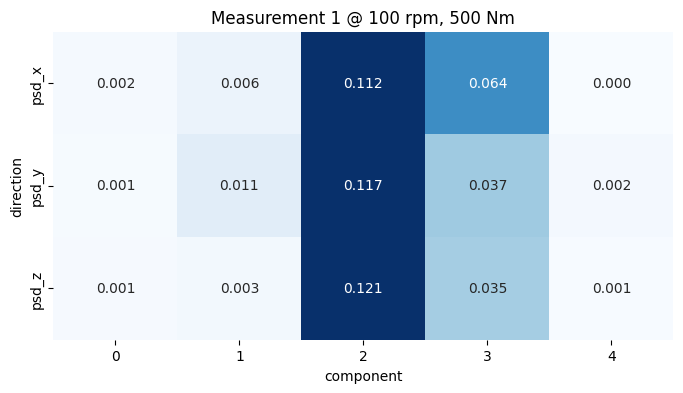

In [8]:
W_train = model.W.reshape(-1, N_COMPONENTS)
df_W_train = pd.DataFrame(W_train)
#display(f'Fold {i}. Shape: {W_train_.shape}')
df_W_train.index = df_V_train.index
df_W_train['direction'] = meta_data_train['direction']

# add operating mode (OM)
df_W_train_with_OM = pd.merge(df_W_train, meta_data_train.drop(columns=['direction']), left_index=True, right_index=True)

# illustrate weights of single measurement 
rpm=100
torque=500
run=1

df_ = df_W_train_with_OM[(df_W_train_with_OM['rotational speed [RPM]']==rpm) &
                          (df_W_train_with_OM['torque [Nm]']==torque) &
                          (df_W_train_with_OM['sample_id']==run)]
df_ = df_.set_index('direction')
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_[list(range(N_COMPONENTS))], annot=True, fmt=".3f", ax=ax, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
ax.set_title(f'Measurement {run} @ {rpm} rpm, {torque} Nm');
ax.set_xlabel('component');

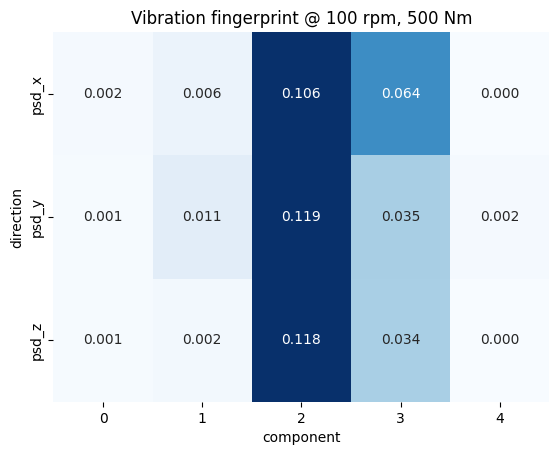

In [9]:
df_ = df_W_train_with_OM[(df_W_train_with_OM['rotational speed [RPM]']==rpm) & (df_W_train_with_OM['torque [Nm]']==torque)]
df_ = df_[list(range(N_COMPONENTS)) + ['direction']].groupby('direction').mean()
fig, ax = plt.subplots()
sns.heatmap(df_, annot=True, fmt=".3f", ax=ax, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
ax.set_title(f'Vibration fingerprint @ {rpm} rpm, {torque} Nm');
ax.set_xlabel('component');

> CODE: This should be merged or replace the code above, since that allows for the user to plot a specific fingerprint. We can add the option to plot all of them.
Computing them should be done prior to any plotting.

Plotting fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [01:15<00:00,  1.01it/s]


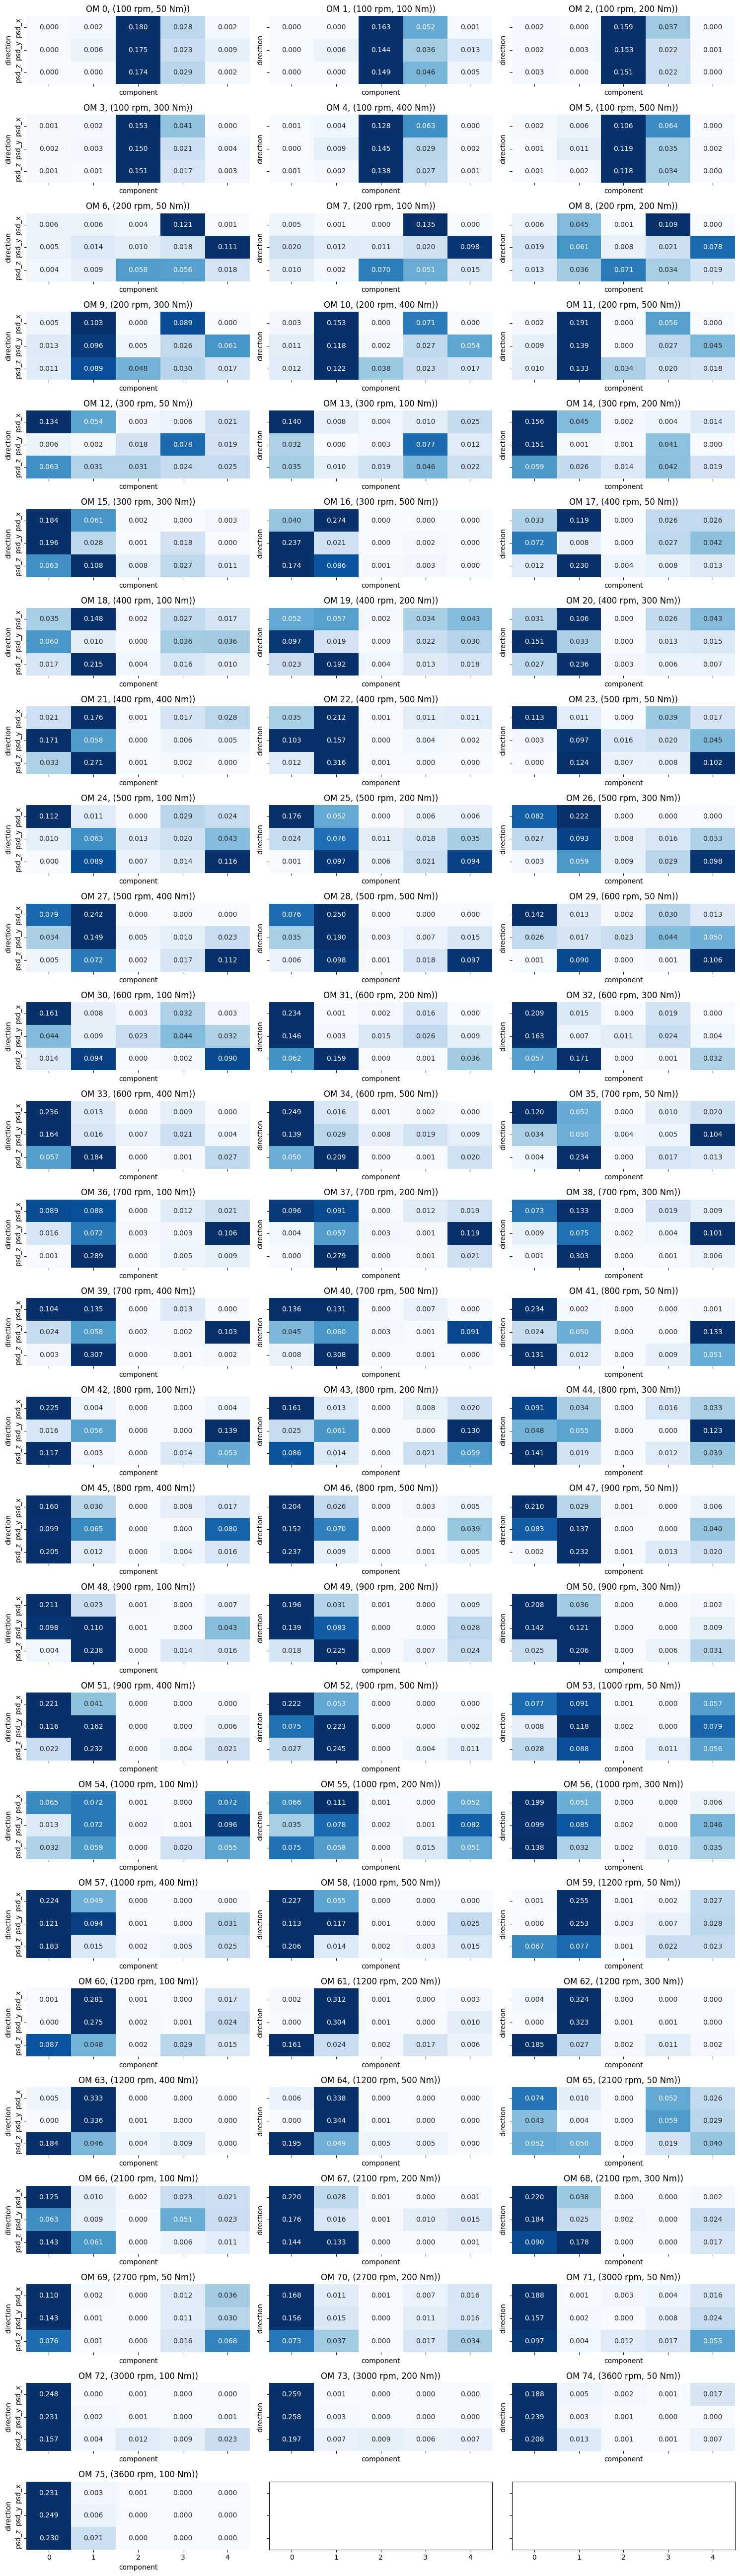

In [10]:
SHOW_FINGERPRINTS = True   # set SHOW_FINGERPRINTS to False, if visualization should not be shown

# for each unique combination of RPM and torque, assign a unique cluster label

df_W_train_with_OM['cluster_label_unique'] = df_W_train_with_OM.groupby(['rotational speed [RPM]', 'torque [Nm]']).ngroup()
cluster_label_unique_name_mapping = df_W_train_with_OM.groupby('cluster_label_unique').first()[['rotational speed [RPM]', 'torque [Nm]']].reset_index()

# extract operating mode wise fingerprints
grouping_vars = ['direction', 'cluster_label_unique']
df_ = df_W_train_with_OM[COMPONENT_COLUMNS + grouping_vars].copy()
fingerprints = {
    om: om_group.groupby(['direction']).mean().drop(columns=['cluster_label_unique']) for om, om_group in df_.groupby('cluster_label_unique')
}


# illustrate fingerprints
if SHOW_FINGERPRINTS:
    nrows = math.ceil(len(fingerprints) / 3)
    fig, axes = plt.subplots(figsize=(15, 2*nrows), nrows=nrows, ncols=3, sharex=True, sharey=True)
    for om, ax in tqdm(zip(fingerprints, axes.flat), total=len(fingerprints), desc='Plotting fingerprints'):
        om_group = fingerprints[om]
        om_group.columns = om_group.columns.astype(str)
        sns.heatmap(om_group, annot=True, fmt=".3f", ax=ax, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
        rpm = cluster_label_unique_name_mapping[cluster_label_unique_name_mapping.cluster_label_unique == om]['rotational speed [RPM]'].values[0]
        Nm = cluster_label_unique_name_mapping[cluster_label_unique_name_mapping.cluster_label_unique == om]['torque [Nm]'].values[0]
        ax.set_title(f'OM {om}, ({rpm} rpm, {Nm} Nm))')
        ax.set_xlabel('component')
    fig.tight_layout()


From the analysis of the operating modes, it is possible to observe that they present distinct performance fingerprints, as can be observed for instance when comparing operating mode (OM) 0 with OM 50. Whereas operating mode 0 predominantly expresses vibrations in the third component related to the noise floor for all vibration directions, operating mode 50 predominantly expresses vibrations in the first two components related to 40 and 80 orders. At the same time, operating modes with similar operating conditions show similar vibration fingerprints. For instance, OM 0 and OM 1 only differ slightly in the torque, which results (as expected) in similar vibration fingerprints.

> At the end of this offline phase, each operating mode has is own performance profile

### Online phase 

The general workflow of the online phase is reported in the figure below.

> [Fabian, can you put the figure of the online phase here?]

> Part of the text below should be simplified [I need a lot of help from Fabian for this job].

This phase can be divided in five steps (See Figure above). The main goals of these phases can be summarized as follow:

1. Windowing for incoming streaming data. The steaming data is divided in batches. This is activity is generally performed to avoid the execution of the methodology for each new received data. In the use case, there is no need of windowing because ... [Fabian, can you complete the sentence?]

2. Detecting of the current operating context. To each time stamp is associated an operating mode among the ones identified in the offline phase. In the use case this activity is straightforward since operating modes are defined up-front by the combination of X and Y .... [Fabian complete] and the testing set cannot have different combination from the one already present in the training set. 

3. Deriving the current performance fingerprint. To each operating mode is associated a performance fingerprint. This activity is the same that is performed in the offline phase [Fabian is this true?]. [To append later before the right code section] 

> I am not sure these two activities below belong to the previous step.

> The data [which data?] is binned as during the offline phase for estimating the performance fingerprints from the validation data

> Each individual direction measurement is used as basis for the decomposition vector y1.

4. Estimating the fingerprint offset. For each [operating mode]/[time step] is computed the _offset_ between the fingerprints extracted online and fingerprints extracted offline. The offset quantifies to what extent the two fingerprints differs. 


5. Deriving alarms based on the anomaly score. Based on the offset, an anomaly score is computed for each time stamp [?!]. The evolution of this score is then monitored over time to decide when to raise the alarm. In this use case, this step is skipped since the timestamps in the testset are not ordered. [ToDo: This needs to be reported better in the preprocessing part]


The first two steps are straightforward and their application leads to a table which... [Fabian rework & complete the sentence once is clear the end result of the first two steps]

> CODE. Robbert, these first two steps should be in just one code section which follows. Currently, there is a code section which is not required





> CODE. Robbert, hide well the code snippet that follows so people don't see the code duplicate. **DONE**
> 
> To do: fix the output from the cell.

In [11]:
# Robbert, the code that follows is (AFAIK) mainly the preprocessing you did already for the training part.
# May you try to abstract a common method which can be applied to both testing and training

df_orders_test, meta_data_test = get_and_preprocess_unhealthy_data(df_data_healthy_test, f, recompute=recompute)

print('All samples from the test set are processed for all folds. Below, we show an excerpt of the first fold.')
print('(1) `df_orders_test_folds` contains the preprocessed and order-transformed vibration bands:')
display(df_orders_test.head())
print('(2) `meta_data_test_folds` contains the process data (rpm, torque) and some additional information (measurement direction):')
display(meta_data_test.head())

Extracting and order-transforming test data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:45<00:00, 37.64s/it]


All samples from the test set are processed for all folds. Below, we show an excerpt of the first fold.
(1) `df_orders_test_folds` contains the preprocessed and order-transformed vibration bands:


,band_0.5-2.5,band_2.5-4.5,band_4.5-6.5,band_6.5-8.5,band_8.5-10.5,band_10.5-12.5,band_12.5-14.5,band_14.5-16.5,band_16.5-18.5,band_18.5-20.5,...,n_82.5-84.5,n_84.5-86.5,n_86.5-88.5,n_88.5-90.5,n_90.5-92.5,n_92.5-94.5,n_94.5-96.5,n_96.5-98.5,n_98.5-100.5,unique_sample_id
0,0.000003,0.000002,0.000009,0.000006,0.000010,0.000045,0.000013,0.000007,0.000011,0.000012,...,17,16,17,17,16,17,17,16,17,1000_300_1_healthy
1,0.000003,0.000002,0.000008,0.000003,0.000020,0.000007,0.000064,0.000042,0.000078,0.000028,...,17,16,17,17,16,17,17,16,17,1000_300_1_healthy
2,0.000006,0.000005,0.000011,0.000003,0.000005,0.000010,0.000012,0.000008,0.000018,0.000003,...,17,16,17,17,16,17,17,16,17,1000_300_1_healthy
3,0.000048,0.000550,0.000532,0.000769,0.000604,0.000195,0.001147,0.000222,0.000136,0.001245,...,45,45,45,45,45,45,45,45,45,2700_50_5_healthy
4,0.000044,0.000335,0.000698,0.000700,0.000721,0.000090,0.000323,0.000280,0.000174,0.000732,...,45,45,45,45,45,45,45,45,45,2700_50_5_healthy


(2) `meta_data_test_folds` contains the process data (rpm, torque) and some additional information (measurement direction):


,rotational speed [RPM],torque [Nm],direction,sample_id,unique_sample_id
0,1000,300,psd_x,1,1000_300_1_healthy
1,1000,300,psd_y,1,1000_300_1_healthy
2,1000,300,psd_z,1,1000_300_1_healthy
3,2700,50,psd_x,5,2700_50_5_healthy
4,2700,50,psd_y,5,2700_50_5_healthy


> Fabian can you add a sentence to comment on the 2 dataframe? Something possibly meaningfull

#### Deriving the current performance fingerprints



In this section, the weight matrix $\mathbf{W}$ is extracted from the testing data. 

> CODE TO DO: move part of this code to source files

In [12]:
# extract df_W_offline and df_W_online
def extract_vibration_weights_per_measurement_period(measurement_periods, col_names, band_cols, normalization, model, verbose=False):
    Ws = []
    for period in tqdm(measurement_periods, disable=not verbose, desc='Extracting vibration weights per measurement period'):
        assert len(period) == 3, 'should have exactly 3 directions per measurement period'
        band_column_names = period.columns[period.columns.str.contains('band_')]
        V = period.set_index(['direction'])[band_column_names]  # already normalized
        W = model.nmf.transform(V.to_numpy())
        W = pd.DataFrame(W, columns=col_names)
        Ws.append({
            'unique_sample_id': period.unique_sample_id.unique()[0],
            'V_normalized': V,
            'W': W
        })
    return pd.DataFrame(Ws)

# extract train vibration measurement periods

df_V_train[['unique_sample_id', 'direction']] = meta_data_train[['unique_sample_id', 'direction']]
train_vibration_measurement_periods = []
for sample_id, group in df_V_train.groupby('unique_sample_id'):
    measurement_period = {
        'start': 'unknown', 
        'stop': 'unknown',
        'group': group,
        'sample_id': sample_id,
    }
    train_vibration_measurement_periods.append(group)

# extract test vibration measurement periods


df_V_test_normalized = normalize_1(df_orders_test, BAND_COLS)
df_ = df_V_test_normalized
df_[['sample_id', 'unique_sample_id', 'direction']] = meta_data_test[['sample_id', 'unique_sample_id', 'direction']]
test_vibration_measurement_periods = []
test_vibration_measurement_periods_meta_data = []
n_index_errors = 0
for unique_sample_id, group in df_.groupby('unique_sample_id'):
    rpm = meta_data_test[meta_data_test['unique_sample_id'] == unique_sample_id]['rotational speed [RPM]'].unique()[0]
    torque = meta_data_test[meta_data_test['unique_sample_id'] == unique_sample_id]['torque [Nm]'].unique()[0]
    try:
        om = cluster_label_unique_name_mapping[
            (cluster_label_unique_name_mapping['rotational speed [RPM]'] == rpm) & 
            (cluster_label_unique_name_mapping['torque [Nm]'] == torque)
        ]['cluster_label_unique'].iloc[0]
    except IndexError:
        n_index_errors += 1
        om = -1
    measurement_period = {
        'start': 'unknown', 
        'stop': 'unknown',
        'group': group,
        'unique_sample_id': unique_sample_id,
        'rpm': rpm,
        'torque': torque,
        'unique_cluster_label': om
    }
    test_vibration_measurement_periods.append(group)
    test_vibration_measurement_periods_meta_data.append(measurement_period)
    
n_total = len(test_vibration_measurement_periods)

    
df_W_offline = extract_vibration_weights_per_measurement_period(train_vibration_measurement_periods, fingerprints[0].columns, BAND_COLS, normalize_1, model)
df_W_online = extract_vibration_weights_per_measurement_period(test_vibration_measurement_periods, fingerprints[0].columns, BAND_COLS, normalize_1, model)

df_W_online.head()

,unique_sample_id,V_normalized,W
0,1000_200_1_pitting_level_3,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
1,1000_200_3_healthy,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
2,1000_300_1_healthy,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
3,1000_300_3_pitting_level_2,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
4,1000_300_3_pitting_level_8,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...


> Fabian, we need some comment on the output above. Is there anything worth to report?

To better understand this matrix, below is illustrated the derived weights for a single measurements [Fabian, what is a single measurement? A time stamp?]. The format of the weights is the same as of the fingerprint shown in the previous section.

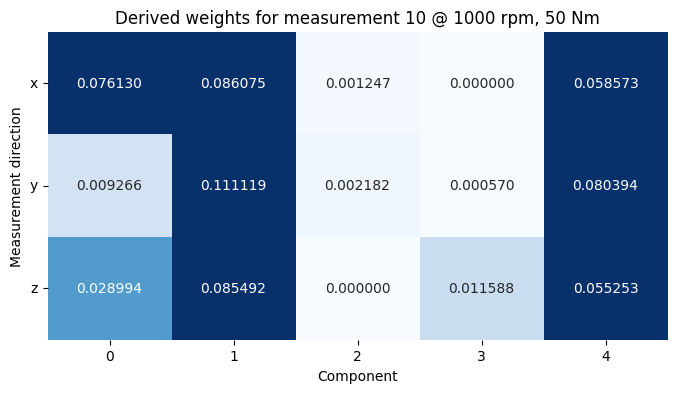

In [13]:
period = 10

usid = df_W_online['unique_sample_id'][period]
df_ = meta_data_test[meta_data_test['unique_sample_id']==usid]
rpm = df_['rotational speed [RPM]'].iloc[0]
torque = df_['torque [Nm]'].iloc[0]

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_W_online['W'][period], annot=True, fmt=".6f", ax=ax, cmap='Blues', vmin=0, vmax=0.05, cbar=False)
ax.set_title(f'Derived weights for measurement {period} @ {rpm} rpm, {torque} Nm');
ax.set_yticklabels(['x', 'y', 'z'], rotation=0)
ax.set_ylabel('Measurement direction')
ax.set_xlabel('Component');

> Fabian, Is there anything worth to report/comment on the table above?
> The table above shows for operating mode @ 100, 500 Nm the performance fingerprint. However, this is just the same type of table we have seen in the offline phase. Maybe we can omit an output

> ToDo: Make clear that one aspect of the methodology (performance profiling) is reached. Next, we check the second part of the methodology: anomaly detection

#### Estimating the fingerprint offset

In order to assess
whether the performance of asset i (i = 1, . . . , n) is normal vs. anomalous, it is necessary to quantify the distance - offset - between the observed and expected fingerprints. More specifically, for each performance measurement yi, the cosine
distance between the derived weights w′i and the fingerprint fij ∈ Fi, corresponding to the detected operating mode Oij , (j = 1, . . . , ki), is used to estimate the offset:

[Fabian, can you put here the eq3 from the paper?]

where || · || is the magnitude of the corresponding vector. 

> Fabian, look at the sentence that follow. Is it worth to report?
> The derived weight vectors represent individual direction measurements as a result of decomposing per individual direction. The weight vectors are appended into a single 15-dimensional vector w′1 that is compared to the fingerprint f1j of the corresponding operating mode O1j

Since the measurements [?!] have no timestamp, it is not possible to order the measurements in time and calculate a cumulative anomaly score.
Therefore, to identify anomalies we perform only the measurement-wise anomaly detection in this section.

Per operating mode, we calculate the offset of the derived weights to the corresponding fingerprint below.

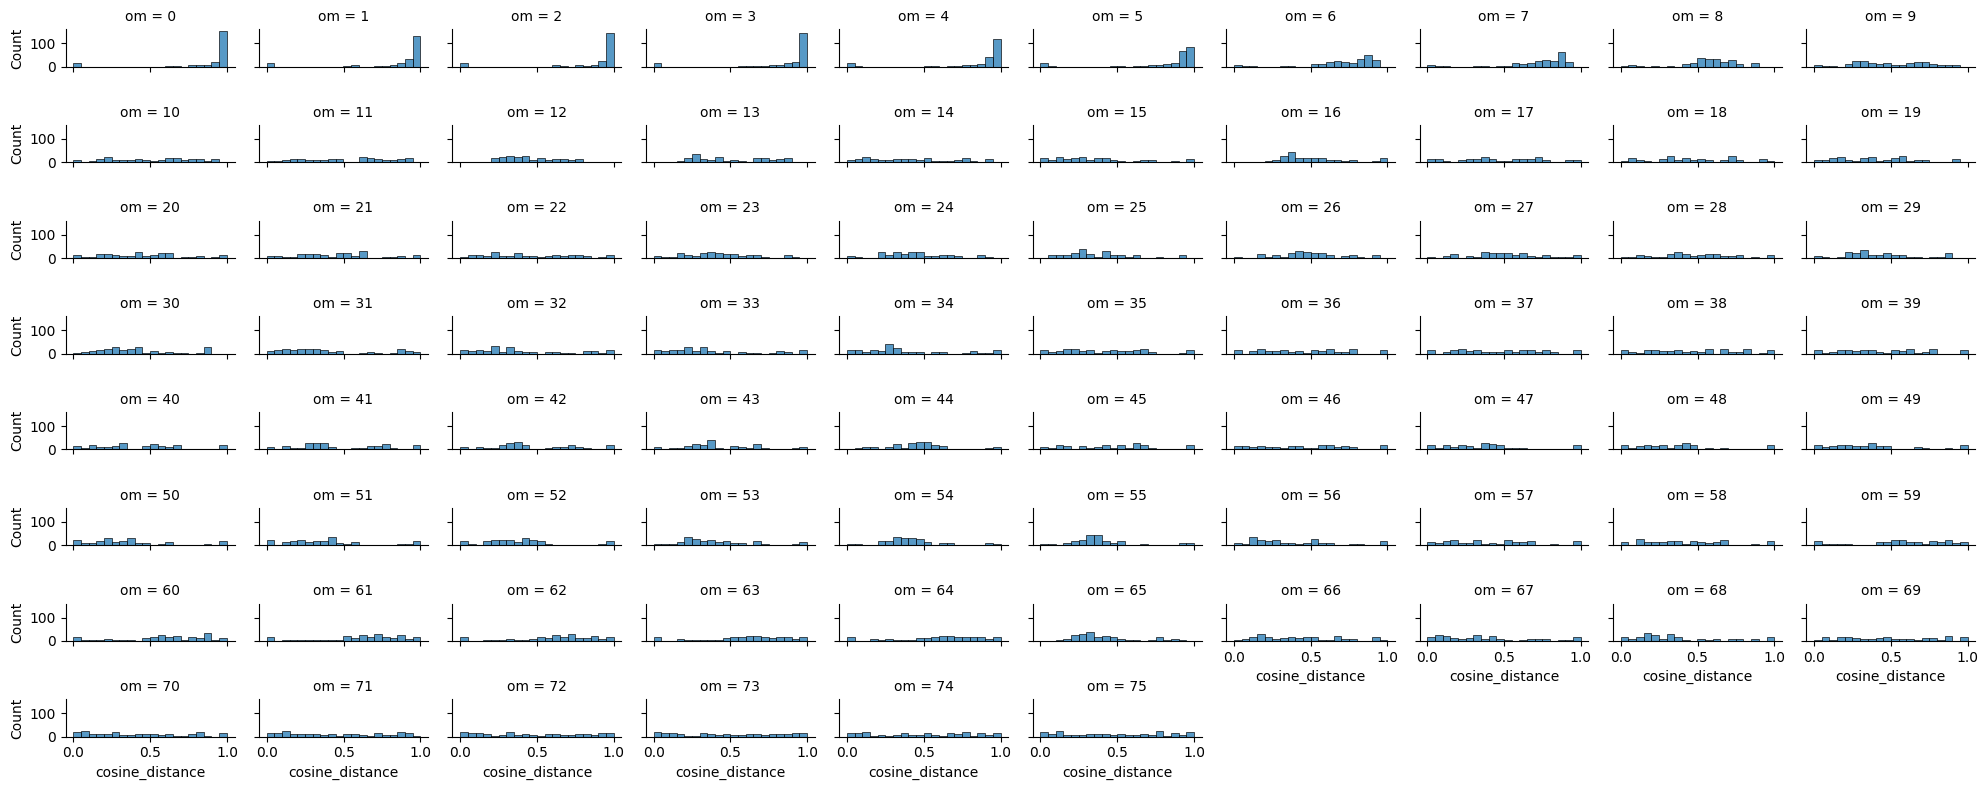

In [14]:
# cell takes around 60 minutes to run (!) --> going to cache the results
SHOW_DISTANCES = False

def calculate_distances_per_measurement_period(measurement_period, fingerprints, verbose=False):
    # pointwise Mahalanobis distance
    fingerprint_matrix = np.array([fingerprints[om].to_numpy().flatten() for om in fingerprints])
    # calculate covariance matrix
    fingerprint_S = np.cov(fingerprint_matrix.T)
    # calculate inverse
    fingerprint_SI = np.linalg.inv(fingerprint_S)
    # calculate mu
    fingerprint_mu = fingerprint_matrix.mean(axis=0)
    df_dist_ = []
    for idx, row in tqdm(measurement_period.iterrows(), total=len(measurement_period), disable=not verbose):
        for om in fingerprints:
            weights = row['W']
            fingerprint = fingerprints[om]
            tmp = {
                'idx': idx,
                'data': row, 
                'om': om, 
                #'frobenius_norm': distance_metrics.frobenius_norm(weights, fingerprint),
                #'frobenius_norm_pow2': distance_metrics.frobenius_norm_v2(weights, fingerprint),
                #'frobenius_norm_sqrt': distance_metrics.frobenius_norm_v3(weights, fingerprint),
                'cosine_distance': distance_metrics.cosine_distance(weights, fingerprint),
                'manhattan_distance': distance_metrics.manhattan_distance(weights, fingerprint),
            }
            df_dist_.append(tmp)
    df_dist_ = pd.DataFrame(df_dist_)
    return df_dist_

# calculate/load distances
fpath_offline = os.path.join(FPATH_DISTANCES, f'df_dist_offline.pkl')
os.makedirs(os.path.dirname(fpath_offline), exist_ok=True)
fpath_online = os.path.join(FPATH_DISTANCES, f'df_dist_online.pkl')
os.makedirs(os.path.dirname(fpath_online), exist_ok=True)
if os.path.exists(fpath_offline) and os.path.exists(fpath_online):
    # load cached distances
    df_dist_offline = pickle.load(open(fpath_offline, 'rb'))
    df_dist_online = pickle.load(open(fpath_online, 'rb'))
else:
    # calculate distances and cache results
    df_dist_offline = calculate_distances_per_measurement_period(df_W_offline, fingerprints=fingerprints)
    pickle.dump(df_dist_offline, open(fpath_offline, 'wb'))
    df_dist_online = calculate_distances_per_measurement_period(df_W_online, fingerprints=fingerprints)
    pickle.dump(df_dist_online, open(fpath_online, 'wb'))


# pivot cosine distance:
# for each measurement period (row), get the distance to each operating mode (column)
df_cosine = df_dist_online[['idx', 'om', 'cosine_distance']].pivot(index='idx', columns='om', values='cosine_distance')
# assign the corresponding operating mode to the given row (if known), else, assign -1
df_cosine[['rpm', 'torque', 'unique_cluster_label']] = pd.DataFrame(test_vibration_measurement_periods_meta_data)[['rpm', 'torque', 'unique_cluster_label']]

g = sns.displot(data=df_dist_offline, 
                x="cosine_distance", col="om", col_wrap=10, height=1, aspect=2, bins=20, kind="hist")

> [Fabian, anything worth to report about the analysis done before?]

Below, we create a pivot table of the cosine distance and compare distances between measurements and their corresponding fingerprints (left) and other fingerprints (right).

Pivot table with distances to all fingerprints (0 - 72), corresponding rpm and torque values, and additional information on the anomaly condition:


om,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,rpm,torque,unique_cluster_label,distance_to_own_cluster_center,pitting,pitting_level
idx,,,,,,,,,,,,,,,,,,,,,
0,0.950980,0.938852,0.964728,0.959624,0.950273,0.934120,0.625390,0.660814,0.489770,0.407545,...,0.541366,0.525917,0.470361,0.492032,1000,200,55,0.067243,True,3
1,0.957429,0.946591,0.970888,0.963298,0.951714,0.935288,0.639242,0.685083,0.438623,0.296894,...,0.500391,0.501929,0.478596,0.483197,1000,200,55,0.000872,False,0
2,0.976039,0.971554,0.972918,0.973461,0.968290,0.956794,0.809215,0.799196,0.660828,0.624474,...,0.102363,0.106919,0.129904,0.109789,1000,300,56,0.000605,False,0
3,0.946655,0.927782,0.958229,0.956602,0.946789,0.927670,0.585453,0.621387,0.512605,0.487824,...,0.353088,0.350476,0.337572,0.340263,1000,300,56,0.170779,True,2
4,0.962091,0.952701,0.963564,0.963490,0.952365,0.933905,0.753778,0.750903,0.561334,0.469809,...,0.205373,0.196455,0.181057,0.180890,1000,300,56,0.070838,True,8


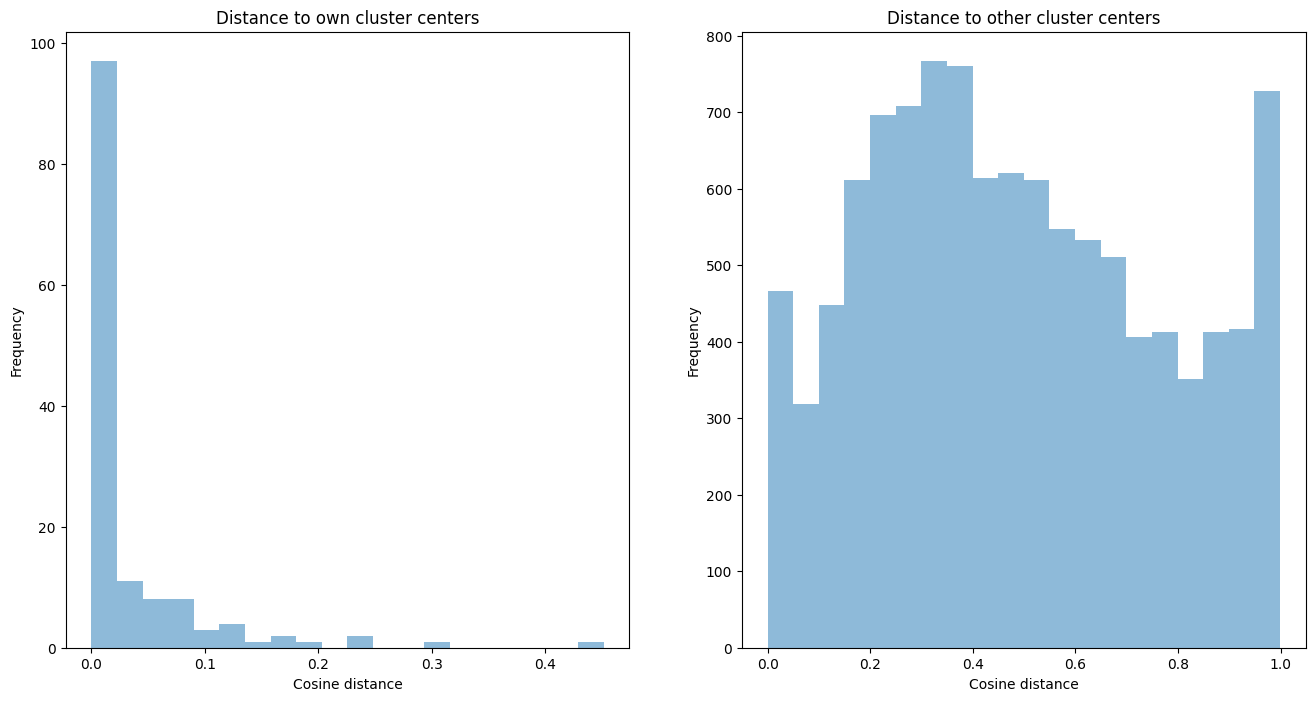

In [15]:
distance_to_own_cluster_center = []
for idx, row in df_cosine.iterrows():
    om = row['unique_cluster_label']
    if om != -1:
        distance_to_own_cluster_center.append(row[om])
    else:
        distance_to_own_cluster_center.append(np.nan)
df_cosine['distance_to_own_cluster_center'] = distance_to_own_cluster_center
df_cosine['pitting'] = df_W_online['unique_sample_id'].str.contains(f'pitting_level_')
df_cosine['pitting_level'] = df_W_online['unique_sample_id'].str.extract(r'pitting_level_(\d)')
df_cosine['pitting_level'] = df_cosine['pitting_level'].fillna(0).astype(int)

print('Pivot table with distances to all fingerprints (0 - 72), corresponding rpm and torque values, and additional information on the anomaly condition:')
display(df_cosine.head())

fig, axes = plt.subplots(figsize=(16, 8), ncols=2)

ax = df_cosine['distance_to_own_cluster_center'].plot(kind='hist', bins=20, ax=axes[0], alpha=0.5, legend=False)
ax.set_title('Distance to own cluster centers')
ax.set_xlabel('Cosine distance')

# plot distance to other cluster centers
ax = df_cosine.drop(columns=['rpm', 'torque', 'unique_cluster_label', 'distance_to_own_cluster_center', 'pitting', 'pitting_level']).melt()['value'].plot(kind='hist', bins=20, ax=axes[1], alpha=0.5, legend=False)
ax.set_title('Distance to other cluster centers')
ax.set_xlabel('Cosine distance');

> [Fabian, anything worth to report about the figure above? If not, then remove it]


Once the XXX performance offset are computed XXX [result previous activity] are computed we finally evaluate to what extent they can be used for anomaly detection.
 
> Unclear. Do we describe how to use these offset in the methodology? No. We replaced Step Deriving alarms based on anomaly score with a "Deriving alarms based on???". So, at this point we are still explaning the methodology I guess.
> From this point on we are just validationg the methodology for anomaly detection

In this section we provide an overview of the performance of the methodology.

As first step, we evaluate whether the performance offset can be exploited for detecting anomalies. For this reason we analyze the relation between offset distance and pitting level.

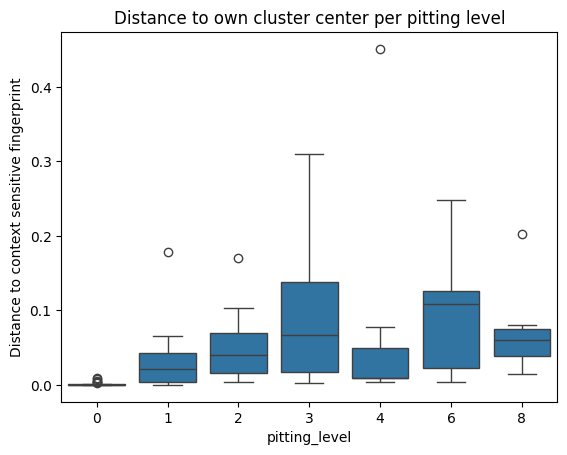

In [16]:
ax = sns.boxplot(data=df_cosine, y='distance_to_own_cluster_center', x='pitting_level')
ax.set_ylabel('Distance to context sensitive fingerprint')
ax.set_title(f'Distance to own cluster center per pitting level');

In the boxplots above it possible to observe a clear difference in terms the offset betweem healthy and faulty gearboxes, i.e. gearboxes which incurred in a pitting. This is expected, as the context-sensitive fingerprint is derived from healthy data without pitting and data with pitting is likely to have vibration patterns not present in the healthy data set.

### ROC-curves

Whether a datapoint is labelled as anomalous depends on a predefined distance threshold.
In this section, we caclulate ROC-curves by varying this distance threshold. [ToDo: explain ROC-curve]

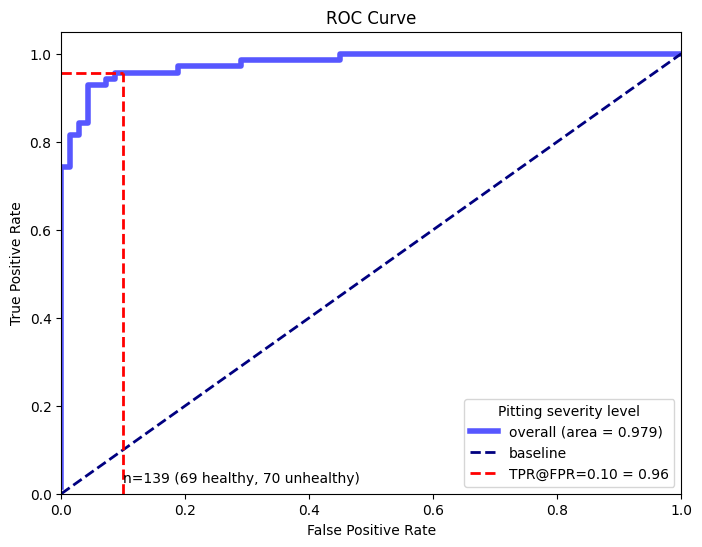

In [17]:
threshold = 0.1

df_cosine = df_cosine[df_cosine.unique_cluster_label != -1]  # removed unknown cluster labels

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the general ROC curve
fpr, tpr, roc_auc = calculate_roc_characteristics(df_cosine)
tpr_at_fpr = calc_tpr_at_fpr_threshold(tpr, fpr, threshold=threshold)
ax.plot(fpr, tpr, color='blue', lw=4, label=f'overall (area = {roc_auc:.3f})', alpha=0.66)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
ax.plot([0, threshold], [tpr_at_fpr, tpr_at_fpr], color='red', lw=2, linestyle='--', label=f'TPR@FPR={threshold:.2f} = {tpr_at_fpr:.2f}')
ax.plot([threshold, threshold], [0, tpr_at_fpr], color='red', lw=2, linestyle='--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve')
n_total = len(df_cosine)
n_healthy = len(df_cosine[df_cosine['pitting'] == False])
n_unhealthy = len(df_cosine[df_cosine['pitting'] == True])
text = f"n={n_total} ({n_healthy} healthy, {n_unhealthy} unhealthy)"
ax.annotate(xy=(0.1, 0.025), text=text)

ax.legend(loc='lower right', title='Pitting severity level');

In the figure above it can be observed that the anomaly detection generally performs well with a area under the curve (AUC) of $0.962$.
Operators aim for a high true positive rate (TPR) while minimizing false alarms (keeping the false positive rate (FPR) low). We track the TPR at a stable FPR of 0.1 (TPR@FPR=0.1), which represents the TPR when there are 10% false positives. In this scenario, the TPR is 97%.

> AMUR: Fabian, I fail to see how the next plot convey usable action point for the operator.

An alternatve objective criterium is to keep the FPR as low as possible at a high TPR.
The plot below illustrates the FPR@TPR=0.1. In the shown fold, FPR@TPR=0.1 is 0.07.

> If useless, I would remove the next code snippet

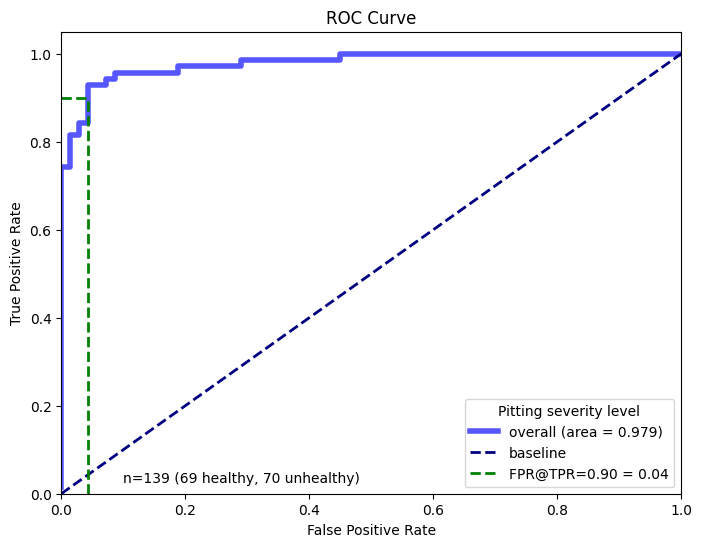

In [18]:

df_cosine = df_cosine[df_cosine.unique_cluster_label != -1]  # removed unknown cluster labels

fig, ax = plt.subplots(figsize=(8, 6))

threshold = 0.90

# Plot the general ROC curve
fpr, tpr, roc_auc = calculate_roc_characteristics(df_cosine)
fpr_at_tpr = calc_fpr_at_tpr_threshold(tpr, fpr, threshold=threshold)
ax.plot(fpr, tpr, color='blue', lw=4, label=f'overall (area = {roc_auc:.3f})', alpha=0.66)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
ax.plot([fpr_at_tpr, fpr_at_tpr], [0, threshold], color='green', lw=2, linestyle='--', label=f'FPR@TPR={threshold:.2f} = {fpr_at_tpr:.2f}')
ax.plot([0, fpr_at_tpr], [threshold, threshold], color='green', lw=2, linestyle='--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve')
n_total = len(df_cosine)
n_healthy = len(df_cosine[df_cosine['pitting'] == False])
n_unhealthy = len(df_cosine[df_cosine['pitting'] == True])
text = f"n={n_total} ({n_healthy} healthy, {n_unhealthy} unhealthy)"
ax.annotate(xy=(0.1, 0.025), text=text)

ax.legend(loc='lower right', title='Pitting severity level');

# Conclusions

In this notebook we illustrated our contextual anomaly detection method on the example of a gearbox that is subject to pitting.
We illustrated how to construct context-sensitive fingerprints and how to utilize the fingerprints for anomaly detection.
We showed that our method is capable to detect anomalies in the test set while keeping the amount of false positives low.


> Mention that to make the analysis more robust, the current analysis should be repeated in folds.
> Mention that with 100 folds, the results can be found in the Fabian's paper

# References
[Fabian's papers XXX].

©, 2023, Sirris